In [1]:
import numpy as np
import torchvision as tv
import matplotlib.pyplot as plt
import torch
import os
import torch.nn as nn
import BasicFunctions as bf
import NNFunctions as nf

from skimage.measure import compare_psnr
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torch.nn import functional as F 

In [2]:
os.chdir('C:\\Users\\Yaroslav\\YandexDisk\\Pr\\Py\\ML\\DataCreation\\output')
X = np.load('X_base_ones9.npz')
y = np.load('Y_base3.npz')
names = bf.all_names[:1]

X_big = bf.bigDataSet(X, names)
y_big = bf.bigDataSet(y, names)

X_norm, y_norm = bf.norm3(X_big, y_big)

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X_norm, y_norm)
batch_size = 4000

train_loader = DataLoader(
    dataset=list(zip(X_train, y_train)), 
    batch_size=batch_size, 
    shuffle=True)

test_loader = DataLoader(
    dataset=list(zip(X_test, y_test)), 
    batch_size=batch_size, 
    shuffle=True)

In [65]:
class HarConv2Block(nn.Module):
    def __init__(self, in_channel=1, out_channels=1, mode='nearest'):
        super(HarConv2Block, self).__init__()
        self.indC1 = nf.IndConv2(in_channel, out_channels, mode=mode)
        self.indC2 = nf.IndConv2(in_channel, out_channels, mode=mode)
        self.indC3 = nf.IndConv2(in_channel, out_channels, mode=mode)
        self.indC4 = nf.IndConv2(in_channel, out_channels, mode=mode)
        self.indC5 = nf.IndConv2(in_channel, out_channels, mode=mode)
    
    def forward(self, x):
        mean1 = torch.mean(torch.mean(x[:, :2, :2], 1, True), 2, True).reshape(x.shape[0], 1, 1, 1)
        mean2 = torch.mean(torch.mean(x[:, 1:, :2], 1, True), 2, True).reshape(x.shape[0], 1, 1, 1)
        mean3 = torch.mean(torch.mean(x[:, :2, 1:], 1, True), 2, True).reshape(x.shape[0], 1, 1, 1)
        mean4 = torch.mean(torch.mean(x[:, 1:, :], 1, True), 2, True).reshape(x.shape[0], 1, 1, 1)
        mean5 = torch.mean(torch.mean(x, 1, True), 2, True).reshape(x.shape[0], 1, 1, 1)
        out = mean1 * self.indC1(x) + mean2 * self.indC2(x)+ mean3 * self.indC3(x) + mean4 * self.indC4(x) + mean5 * self.indC5(x)
        return out

In [66]:
class HardconvNet(nn.Module):
    def __init__(self, in_channel=1, hiden=1, out_channels=1, mode='nearest'):
        super(HardconvNet, self).__init__()
        self.Hardblock = HarConv2Block(mode=mode)
        
    def forward(self, x):
        out = self.Hardblock(x)
        return out

In [4]:
class convNet(nn.Module):
    def __init__(self, in_channel=1, hiden=1, out_channels=1, mode='nearest'):
        super(convNet, self).__init__()
        self.indC1 = nf.IndConv2(in_channel, in_channel * hiden, mode=mode)
        self.indC2 = nf.IndConv2(in_channel * hiden, in_channel * hiden, mode=mode)
        self.indC3 = nf.IndConv2(in_channel * hiden, out_channels, mode=mode)

    def forward(self, x):
        out = F.relu(self.indC1(x))
        out = F.relu(self.indC2(out))
        out = self.indC2(out)
        return out

In [5]:
cuda_net = convNet()
cuda_net = cuda_net.cuda()

In [67]:
cuda_net = HardconvNet()
cuda_net = cuda_net.cuda()

In [68]:
learning_rate = 0.001
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(cuda_net.parameters(), lr=learning_rate)

In [69]:
train_cuda_MSE, test_cuda_MSE = nf.net_cuda_training(cuda_net, train_loader, test_loader,
                                                     criterion, learning_rate, 20)

tensor([[[[-0.0905, -0.0630, -0.1108],
          [ 0.0930, -0.0780, -0.2360],
          [ 0.0182,  0.0882, -0.0655]]],


        [[[-0.0551, -0.0547, -0.0964],
          [ 0.0768, -0.0502, -0.1612],
          [ 0.0247,  0.0847, -0.0402]]],


        [[[-0.0101, -0.0005, -0.0132],
          [ 0.0092, -0.0063, -0.0232],
          [ 0.0117,  0.0239, -0.0029]]],


        ...,


        [[[-0.0435, -0.0985, -0.2062],
          [ 0.1934, -0.1063, -0.3470],
          [-0.0031,  0.0874, -0.1038]]],


        [[[-0.0516, -0.0525, -0.0985],
          [ 0.0869, -0.0559, -0.1707],
          [ 0.0220,  0.0802, -0.0452]]],


        [[[-0.0935, -0.0570, -0.0988],
          [ 0.0797, -0.0726, -0.2150],
          [ 0.0117,  0.0788, -0.0454]]]],
       device='cuda:0', grad_fn=<ThAddBackward>)
tensor([[[[-0.0394, -0.0299, -0.0709],
          [ 0.0593, -0.0341, -0.1162],
          [ 0.0232,  0.0708, -0.0266]]],


        [[[-0.0694, -0.1087, -0.1879],
          [ 0.1768, -0.1026, -0.3349],
          [ 

       device='cuda:0', grad_fn=<ThAddBackward>)
tensor([[[[-0.0184, -0.1063, -0.1917],
          [ 0.2822, -0.0670, -0.3682],
          [ 0.0933,  0.1721, -0.0951]]],


        [[[-0.0401, -0.0219, -0.0821],
          [ 0.1241, -0.0434, -0.1929],
          [ 0.0463,  0.1120, -0.0364]]],


        [[[-0.0767, -0.0651, -0.1139],
          [ 0.1620, -0.0601, -0.2587],
          [ 0.0694,  0.1254, -0.0315]]],


        ...,


        [[[-0.0440, -0.0307, -0.0743],
          [ 0.1109, -0.0380, -0.1630],
          [ 0.0442,  0.1082, -0.0221]]],


        [[[-0.0424, -0.0486, -0.1158],
          [ 0.1671, -0.0477, -0.2307],
          [ 0.0683,  0.1265, -0.0439]]],


        [[[-0.0378, -0.0191, -0.0583],
          [ 0.0833, -0.0302, -0.1295],
          [ 0.0385,  0.0955, -0.0192]]]],
       device='cuda:0', grad_fn=<ThAddBackward>)
tensor([[[[-0.0397, -0.0449, -0.1108],
          [ 0.1781, -0.0547, -0.2648],
          [ 0.0836,  0.1306, -0.0498]]],


        [[[-0.0787, -0.0549, -0.1113],
  

       device='cuda:0', grad_fn=<ThAddBackward>)
tensor([[[[ 0.0056, -0.0159, -0.0788],
          [ 0.1832, -0.0080, -0.1802],
          [ 0.0935,  0.1644, -0.0108]]],


        [[[-0.0149, -0.0151, -0.0602],
          [ 0.1792, -0.0230, -0.2042],
          [ 0.1085,  0.1613, -0.0111]]],


        [[[-0.0150,  0.0006, -0.0390],
          [ 0.0894, -0.0110, -0.1002],
          [ 0.0481,  0.1038, -0.0014]]],


        ...,


        [[[-0.0341, -0.0379, -0.0831],
          [ 0.2403, -0.0365, -0.2953],
          [ 0.1207,  0.1827,  0.0106]]],


        [[[-0.0144, -0.0055, -0.0555],
          [ 0.1298, -0.0121, -0.1413],
          [ 0.0717,  0.1301, -0.0022]]],


        [[[-0.0158, -0.0058, -0.0564],
          [ 0.1460, -0.0163, -0.1637],
          [ 0.0785,  0.1423, -0.0067]]]],
       device='cuda:0', grad_fn=<ThAddBackward>)
tensor([[[[-0.0031, -0.0193, -0.0947],
          [ 0.2358, -0.0152, -0.2617],
          [ 0.1124,  0.1814,  0.0013]]],


        [[[-0.0067, -0.0589, -0.1173],
  

       device='cuda:0', grad_fn=<ThAddBackward>)
tensor([[[[-0.0025,  0.0281, -0.0245],
          [ 0.2296,  0.0043, -0.2556],
          [ 0.1586,  0.2092,  0.0486]]],


        [[[ 0.0278,  0.0190, -0.0372],
          [ 0.1509,  0.0154, -0.1288],
          [ 0.0956,  0.1627,  0.0177]]],


        [[[ 0.0762,  0.0196, -0.0432],
          [ 0.2547,  0.0358, -0.1754],
          [ 0.1628,  0.2299,  0.0026]]],


        ...,


        [[[ 0.0156,  0.0225, -0.0228],
          [ 0.1705,  0.0062, -0.1563],
          [ 0.1142,  0.1770,  0.0173]]],


        [[[ 0.0138,  0.0373, -0.0191],
          [ 0.1910,  0.0052, -0.1965],
          [ 0.1285,  0.1865,  0.0165]]],


        [[[ 0.0009,  0.0147, -0.0298],
          [ 0.1051,  0.0096, -0.0930],
          [ 0.0753,  0.1265,  0.0243]]]],
       device='cuda:0', grad_fn=<ThAddBackward>)
tensor([[[[ 0.0475,  0.0194, -0.0522],
          [ 0.2565,  0.0344, -0.2222],
          [ 0.1771,  0.2319,  0.0441]]],


        [[[ 0.0164,  0.0257, -0.0298],
  

KeyboardInterrupt: 

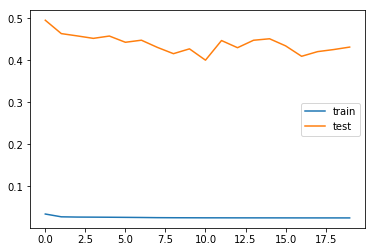

In [9]:
bf.tt_plot(train_cuda_MSE, test_cuda_MSE)

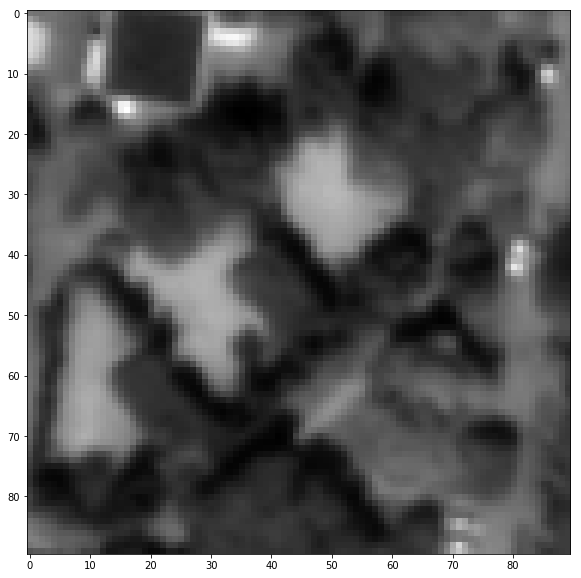

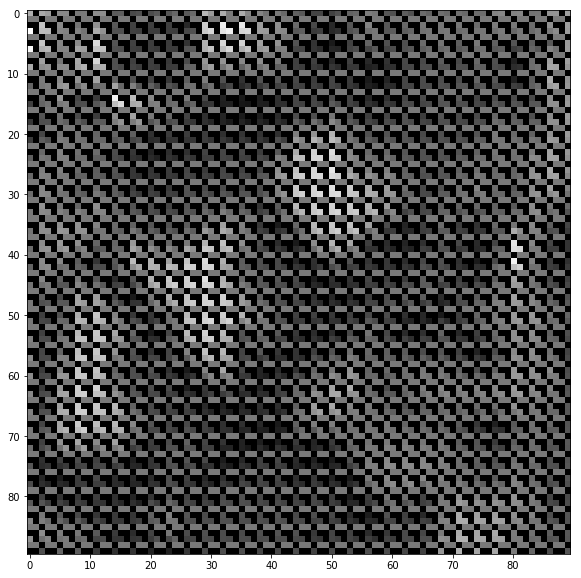

In [13]:
bf.pic_90x90(y_norm)
bf.pic_90x90(nf.rec_pic(cuda_net, X_norm))